## Example of using LTFMSelector for Classification
As an example, we will use LTFMSelector to deal with the UCI ML Breast Cancer Wisconsin dataset

In [ ]:
from ltfmselector import LTFMSelector

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer

In [2]:
# Load breast cancer dataset
cancer_dataset = load_breast_cancer()

# Get data
X = cancer_dataset['data']

# Get target
y = cancer_dataset['target']
# - 0: malignant tumor
# - 1: benign tumor

# Get feature names
feature_names = cancer_dataset['feature_names']

# Get description
dataset_description = cancer_dataset['DESCR']

In [3]:
# Convert data into pandas DataFrame
cancer_df = pd.DataFrame(
    np.c_[X, y], columns = np.append(feature_names, ['target'])
)

The data will then be split for training and testing.

Note: It is important that the training datasets (`X`) are passed as `pandas.DataFrame` and the label (`y`) as `pandas.Series`. Other forms will be accomodated for in later versions.

In [4]:
# Split the dataset for training and test
X_df = cancer_df.drop(['target'], axis=1)
y_df = cancer_df['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=5)

y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

In [5]:
# Carry out feature scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=feature_names)
X_test  = pd.DataFrame(sc.transform(X_test), columns=feature_names)

We will now train an agent using LTFMSelector to select features and a prediction models, tailored to each sample.

When initializing LTFMSelector, one necessary hyperparameter is the number of episodes, over which an agent is trained. My personal recommendation is set roughly 2-3 times the number of training examples.
 - So for example here, we have 455 training examples: Hence, ~1300 episodes

Another hyperparameter that should be set is `ptype`, which should be set to `classification` for this example.

If `pModels=None`, a default choice of:
 - Support Vector Machine
 - Random Forest
 - Gaussian Naive-Bayes
will be implemented, all using the scikit-learn library with default hyperparameters. Users can also pass a list of classifier objects, which must have `fit` and `predict` call functions.

In [6]:
# Training an agent using LTFMSelector to select features and an appropriate prediction model tailored to each sample
AgentSelector = LTFMSelector(30, pType='classification') # If you got time, go for 1300

Train the agent by passing the training examples and label.

The hyperparameter `agent_neuralnetwork` receives as an input a PyTorch neural network which will be used to learn the agent's policy. If `None`, a feed-forward (multilayer-perceptron) of with two hidden layers, each with 1024 units will be used.

`lr` refers to the learning rate of the `AdamW` optimizer, used to update the policy network.

The `fit` function returns a `dict<dict>` object, storing meta-information during the training process.

Note: Just for demo purposes, training an agent over 1300 episodes may take some time but if you are simply interested in getting a feel for the interface then just set the number of episodes to 30 or less for now.

In [7]:
# Now letting the agent train, this could take some time ...
doc = AgentSelector.fit(X_train, y_train, agent_neuralnetwork=None, lr=1e-5)



=== Episode 1 === === ===

Correct prediction
True Output: 1.0 | Prediction: 1.0

Episode terminated:
- Iterations                 : 88
- Features selected          : 28.0
- Accumulated reward         : -53.34
- Prediction model           : 1
- Prediction model #(change) : 6


=== Episode 2 === === ===

Correct prediction
True Output: 0.0 | Prediction: 0.0

Episode terminated:
- Iterations                 : 3
- Features selected          : 2.0
- Accumulated reward         : -0.02
- Prediction model           : 0
- Prediction model #(change) : 0


=== Episode 3 === === ===

Correct prediction
True Output: 0.0 | Prediction: 0.0

Episode terminated:
- Iterations                 : 21
- Features selected          : 13.0
- Accumulated reward         : -3.17
- Prediction model           : 2
- Prediction model #(change) : 4


=== Episode 4 === === ===

Correct prediction
True Output: 1.0 | Prediction: 1.0

Episode terminated:
- Iterations                 : 9
- Features selected          : 8.

In [8]:
# To test the trained agent on the test dataset
y_pred, doc_test = AgentSelector.predict(X_test)



=== Test sample 0 === === ===
Prediction: 0.0

Episode terminated:
- Iterations                 : 66
- Features selected          : 15.0
- Accumulated reward         : -21.44
- Prediction model           : 0
- Prediction model #(change) : 29


=== Test sample 1 === === ===
Prediction: 1.0

Episode terminated:
- Iterations                 : 12
- Features selected          : 6.0
- Accumulated reward         : -0.11
- Prediction model           : 2
- Prediction model #(change) : 5


=== Test sample 2 === === ===
Prediction: 1.0

Episode terminated:
- Iterations                 : 42
- Features selected          : 14.0
- Accumulated reward         : -4.37
- Prediction model           : 0
- Prediction model #(change) : 23


=== Test sample 3 === === ===
Prediction: 1.0

Episode terminated:
- Iterations                 : 25
- Features selected          : 9.0
- Accumulated reward         : -1.23
- Prediction model           : 0
- Prediction model #(change) : 14


=== Test sample 4 === === ==

In [9]:
# Let's check out the classification accuracy
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.956140350877193


Now assuming you're satisfied with the performance, the next things to investigate might be the following:
1. Which features, and prediction model were selected to make a prediction about test sample 42?
2. Which features were most important for class 0 and 1?
3. Which prediction models seem to best suit this problem?

In [10]:
# 1. Which features, and prediction model were selected to make a prediction about test sample 42?
sample42_doc = doc_test[42]
print("For test sample 42:")
print(f" - True class: {y_test[42]} | Prediction: {y_pred[42]}")
print(f" - Prediction model selected: {AgentSelector.pModels[sample42_doc['PredModel']]}")
print(" - Features selected: ")
for i, feature_sel in enumerate(sample42_doc['Mask']):
    if feature_sel == 1.:
        print(f"   {i}: {feature_names[i]}")

For test sample 42:
 - True class: 1.0 | Prediction: 1.0
 - Prediction model selected: SVC()
 - Features selected: 
   0: mean radius
   14: smoothness error
   16: concavity error
   23: worst area
   24: worst smoothness
   26: worst concavity
   29: worst fractal dimension


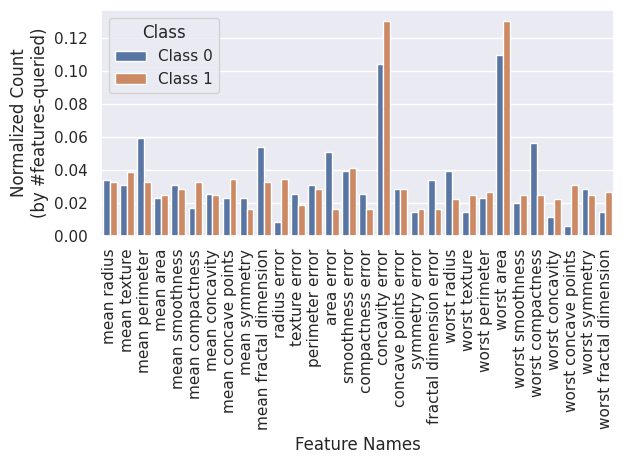

In [11]:
# 2. Which features were most important for class 0 and 1?

# Gather up indices according to predicitons
idxs_class0 = np.where(y_pred==0); idxs_class1 = np.where(y_pred==1)

# To gauge feature importance: One can simply count the number of time a feature was recruited when making a prediction
mask_class0 = np.zeros(len(feature_names))
mask_class1 = np.zeros(len(feature_names))

# Summing up feature occurence for predictions of class 0
for i in idxs_class0[0]:
    mask_class0 += doc_test[i]['Mask']

# Summing up feature occurence for predictions of class 1
for i in idxs_class1[0]:
    mask_class1 += doc_test[i]['Mask']

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
feature_count_df_0 = pd.DataFrame(
    {
        'Feature': feature_names, 'Count': mask_class0,
        'Class': ['Class 0' for _ in feature_names]
    }
)
feature_count_df_1 = pd.DataFrame(
    {
        'Feature': feature_names, 'Count': mask_class1,
        'Class': ['Class 1' for _ in feature_names]
    }
)
# Normalize the feature counts by the total number of times features were recruited
feature_count_df_0['Count'] = feature_count_df_0['Count'] / feature_count_df_0['Count'].sum()
feature_count_df_1['Count'] = feature_count_df_1['Count'] / feature_count_df_1['Count'].sum()

# Concatenating the two dataframes
feature_count_df = pd.concat([feature_count_df_0, feature_count_df_1])

# Plotting bar plots
sns.barplot(data=feature_count_df, x="Feature", y="Count", hue="Class")
plt.xlabel('Feature Names')
plt.xticks(rotation=90)
plt.ylabel('Normalized Count\n(by #features-queried)')
plt.tight_layout()
plt.show()

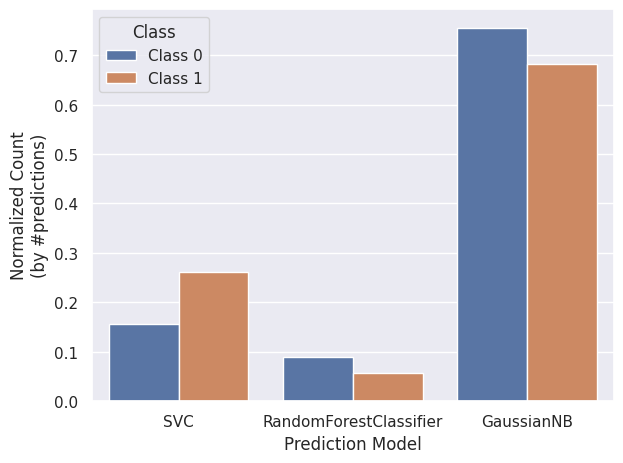

In [12]:
# 3. Which prediction models seem to best suit this problem?
pModelsName = [str(p).split('(')[0] for p in AgentSelector.pModels]

df_pModels_class0 = pd.DataFrame(
    {
        'pModel': pModelsName, 'Count': [0, 0, 0],
        'Class': ['Class 0', 'Class 0', 'Class 0']
    }
)
df_pModels_class0 = df_pModels_class0.set_index('pModel')
df_pModels_class1 = pd.DataFrame(
    {
        'pModel': pModelsName, 'Count': [0, 0, 0],
        'Class': ['Class 1', 'Class 1', 'Class 1']
    }
)
df_pModels_class1 = df_pModels_class1.set_index('pModel')

for i in doc_test:
    if y_pred[i] == 0.0:
        df_pModels_class0.at[pModelsName[doc_test[i]['PredModel']], 'Count'] += 1
    elif y_pred[i] == 1.0:
        df_pModels_class1.at[pModelsName[doc_test[i]['PredModel']], 'Count'] += 1

# Normalizing the prediciton model counts by total number of predictions
df_pModels_class0['Count'] = df_pModels_class0['Count'] / df_pModels_class0['Count'].sum()
df_pModels_class1['Count'] = df_pModels_class1['Count'] / df_pModels_class1['Count'].sum()

# Concatenating the two dataframes
df_pModels = pd.concat([df_pModels_class0, df_pModels_class1])
df_pModels.reset_index(inplace=True)

# Plotting bar plots
sns.barplot(data=df_pModels, x="pModel", y="Count", hue="Class")
plt.xlabel('Prediction Model')
plt.ylabel('Normalized Count\n(by #predictions)')
plt.tight_layout()
plt.show()